In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

# Import Data

In [2]:
# Import training and holdout dataframes
train_df = pd.read_csv('kc_house_data_train.csv')
hold_df = pd.read_csv('kc_house_data_test_features.csv')

# Create Features

In [3]:
# Print column names
print(train_df.keys())

Index(['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [4]:
# Function to create house ages
def set_ages(df):
    df['age'] = 2015 - df['yr_built']
    return df

# Create house ages for dataframes
# train_df = set_age(train_df)
# hold_df = set_age(hold_df)

In [5]:
# Function to transform year renovated
def trans_ren(df):
    filt = df['yr_renovated'] != 0
    df['yr_renovated'] = np.where(filt, (df['yr_renovated']-1933), 0)
    return df

# Transorm year renovated for dataframes
# train_df = trans_ren(train_df)
# hold_df = trans_ren(hold_df)

In [6]:
# Function for creating grade dummy variables
def set_grades(df):
    dummies = pd.get_dummies(df['grade'], prefix='grade', drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    for grade in dummies.keys():
        df[grade] = df[grade] * df['sqft_living']
    return df

# Create grade dummy variables for dataframes
# train_df = set_grades(train_df)
# hold_df = set_grades(hold_df)


In [7]:
# Function for creating condition dummy variables
def set_conditions(df):
    dummies = pd.get_dummies(df['condition'], prefix='condition', drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    for condition in dummies.keys():
        df[condition] = df[condition] * df['sqft_living']
    return df

In [8]:
# Function for creating year dummy variables
def set_years(df):
    df['year'] = df['date'].apply(lambda x: int(x[0:4]))
    dummies = pd.get_dummies(df['year'], drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    for year in dummies.keys():
        df[year] = df[year] * df['sqft_living']
    df.drop('year', axis=1, inplace=True)
    return df

# Create year dummy variables for dataframes
# train_df = set_years(train_df)
# hold_df = set_years(hold_df)

In [9]:
# Function for creating month dummy variables
def set_months(df):
#     months = {1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun',
#               7:'jul', 8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'}
    df['month'] = df['date'].apply(lambda x: int(x[4:6]))
    dummies = pd.get_dummies(df['month'], drop_first=True)
#     for key in dummies.keys():
#         if key in months.keys():
#             dummies.rename({key : months[key]}, axis=1, inplace=True)
    df = pd.concat([df, dummies], axis=1)
    for month in dummies.keys():
        df[month] = df[month] * df['sqft_living']
    df.drop('month', axis=1, inplace=True)
    return df

# Create month dummy variables for dataframes
# train_df = set_months(train_df)
# hold_df = set_months(hold_df)

In [10]:
# Function for creating zipcode dummy variables
def set_zipcodes(df):
    dummies = pd.get_dummies(df['zipcode'], drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    for zipcode in dummies.keys():
        df[zipcode] = df[zipcode] * df['sqft_living']
    return df

# Create zipcode dummy variables for dataframes
# train_df = set_zipcodes(train_df)
# hold_df = set_zipcodes(hold_df)

In [11]:
# Function to transform waterfront variable
def trans_waterfront(df):
    df['waterfront'] = df['waterfront'] * df['sqft_living']
    return df

# Transform waterfront variable for dataframes
# train_df = trans_waterfront(train_df)
# hold_df = trans_waterfront(hold_df)

# Apply Features to Dataframes

In [12]:
# Function to create all features for dataframes
def create_featuers(df):
    df = set_ages(df)
    df = trans_ren(df)
    df = set_years(df)
    df = set_months(df)
    df = set_zipcodes(df)
    df = trans_waterfront(df)
    df = set_grades(df)
    df = set_conditions(df)
    return df

# Create all features for dataframes
train_df = create_featuers(train_df)
hold_df = create_featuers(hold_df)

In [13]:
# Function to add 0 values for any missing columns
def compare_cols(df1, df2):
    for col in df1:
        if col in df2:
            pass
        else:
            df2[col] = 0
    for col in df2:
        if col in df1:
            pass
        else:
            df1[col] = 0
    return df1, df2

# Add 0 values for any missing columns in dataframes
train_df, hold_df = compare_cols(train_df, hold_df)

# Fix Outliers

In [14]:
# Function to transform extreme values
def fix_outliers(df, cols):
    for col in cols:
        if df[col].eq(0).any():
            filt = df[col] == 0
            df[f'{col}_nan'] = np.where(filt, np.nan, df[col])
            std = df[f'{col}_nan'].std()
            mean = df[f'{col}_nan'].mean()
            del df[f'{col}_nan']
        else:
            std = df[col].std()
            mean = df[col].mean()
        value = mean+(8*std)
        df[col] = df[col].apply(lambda x: value if (x>value) else x)
    return df

# Transform extreme values for specified columns dataframes
outlier_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above',
                'sqft_basement', 'sqft_living15', 'sqft_lot15']

train_df = fix_outliers(train_df, outlier_cols)
hold_df = fix_outliers(hold_df, outlier_cols)


# EDA

In [18]:
# Create list of features
ignore = ['Unnamed: 0', 'id', 'price', 'date', 'yr_built', 'zipcode',
          'lat', 'long', 'sqft_living', 'sqft_above','grade', 'condition']
features = train_df.drop(columns=ignore, axis=1).keys()
features

Index([     'bedrooms',     'bathrooms',      'sqft_lot',        'floors',
          'waterfront',          'view', 'sqft_basement',  'yr_renovated',
       'sqft_living15',    'sqft_lot15',
       ...
             'grade_8',       'grade_9',      'grade_10',      'grade_11',
            'grade_12',      'grade_13',   'condition_2',   'condition_3',
         'condition_4',   'condition_5'],
      dtype='object', length=107)

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


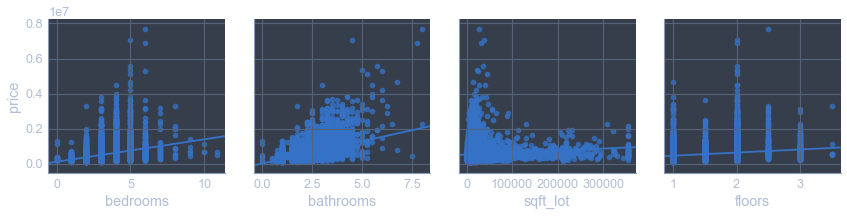

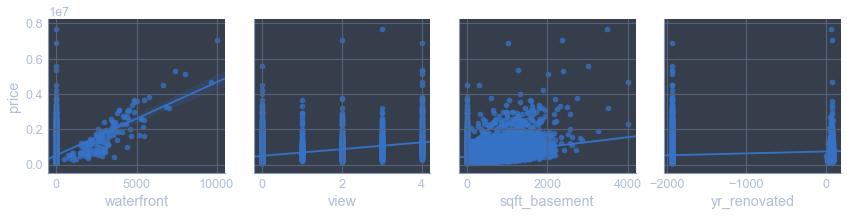

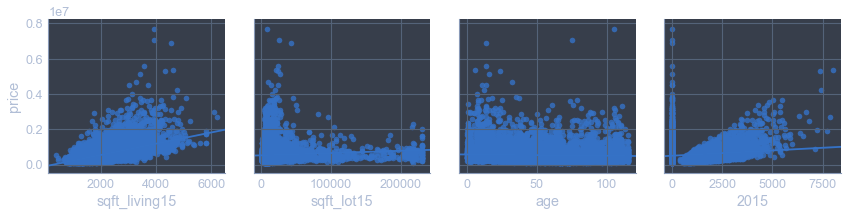

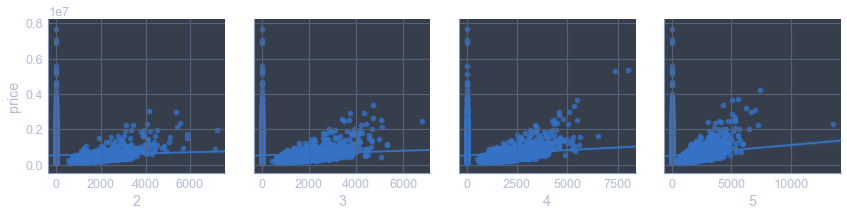

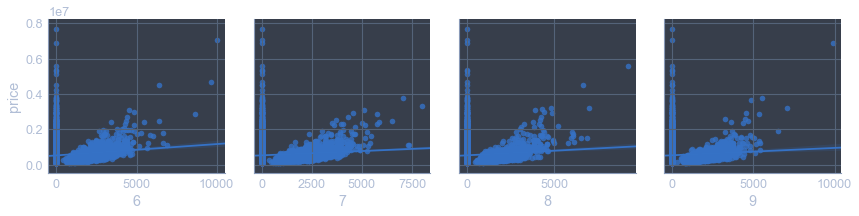

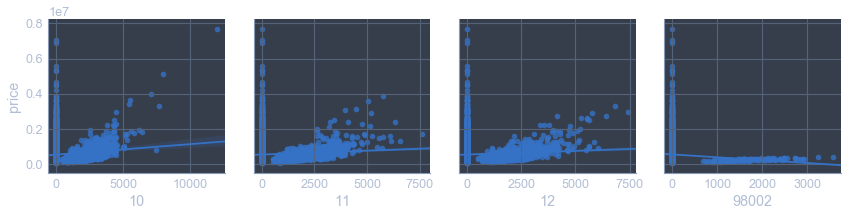

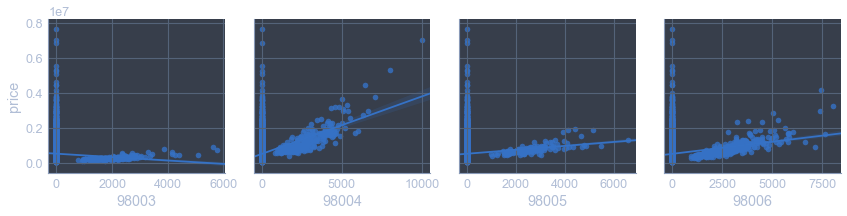

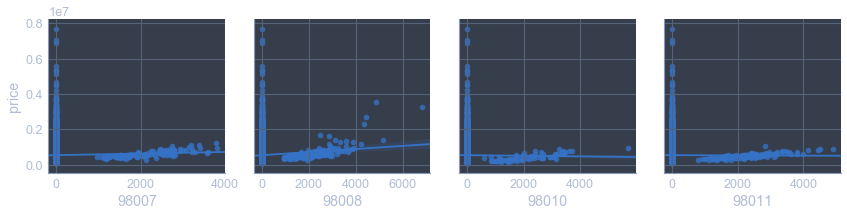

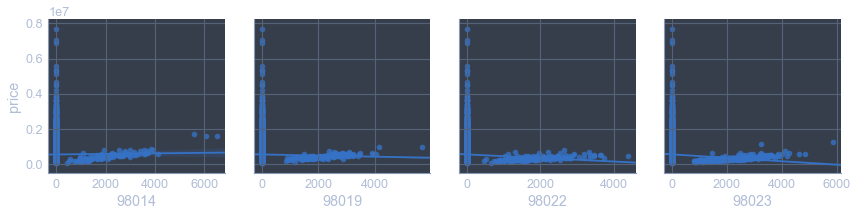

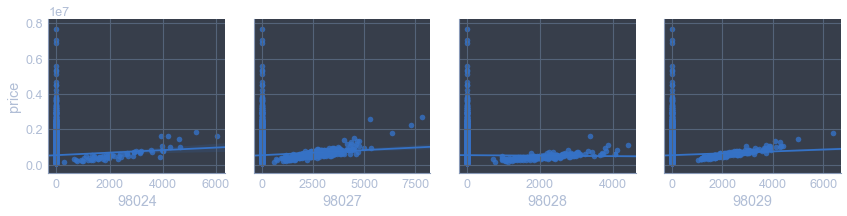

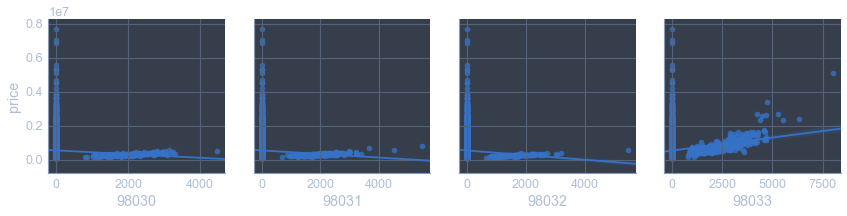

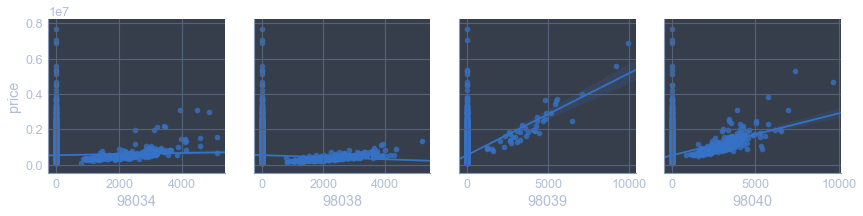

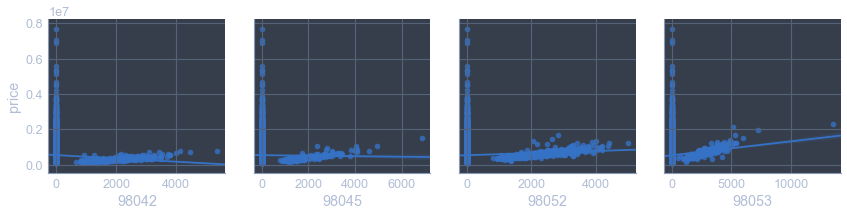

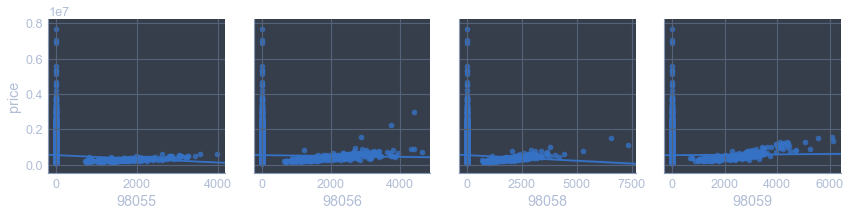

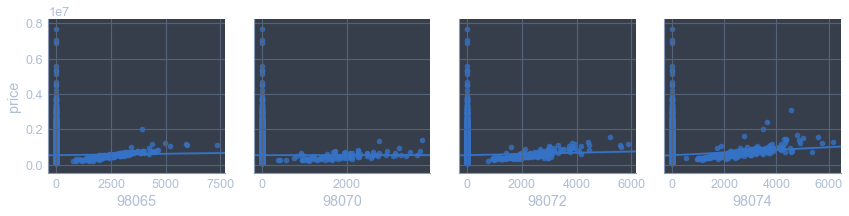

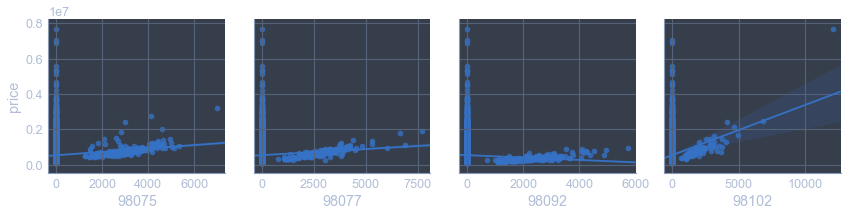

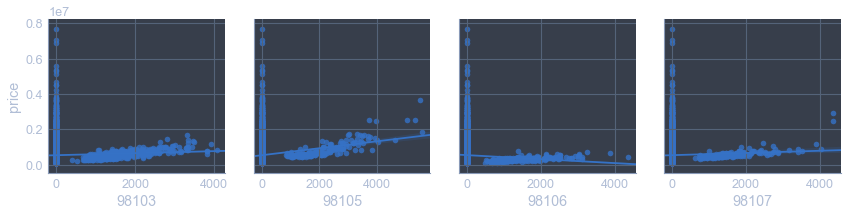

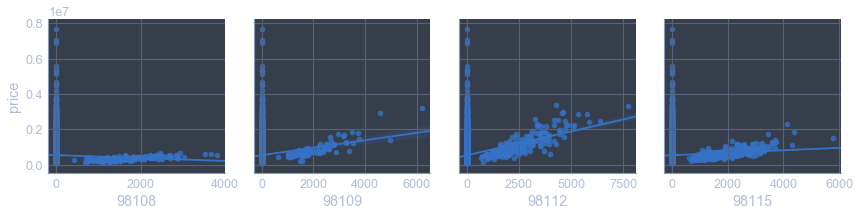

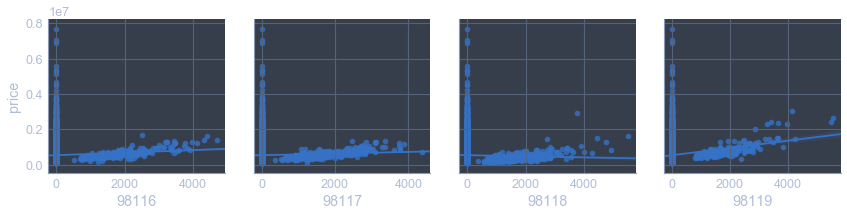

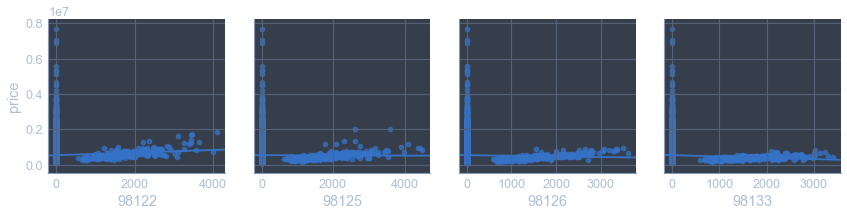

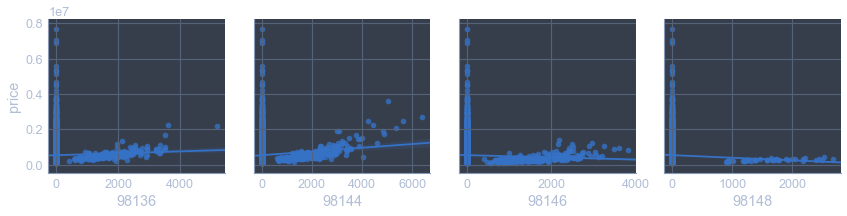

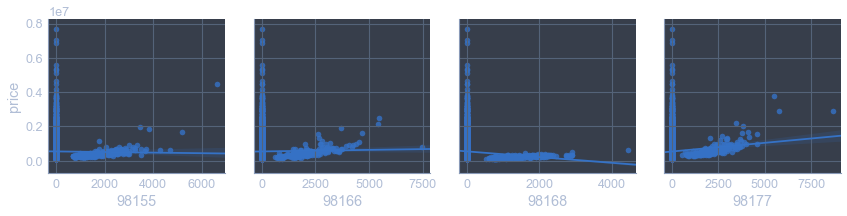

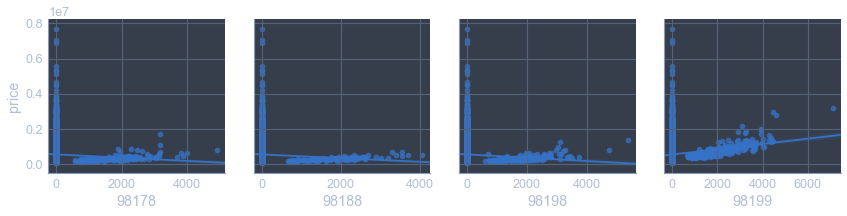

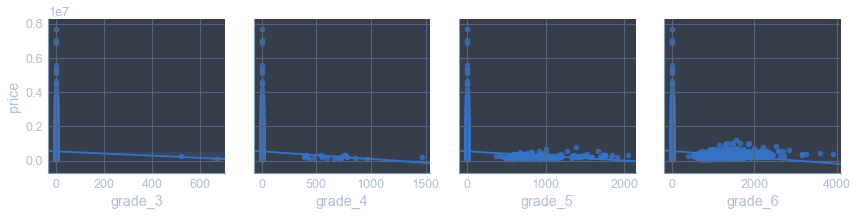

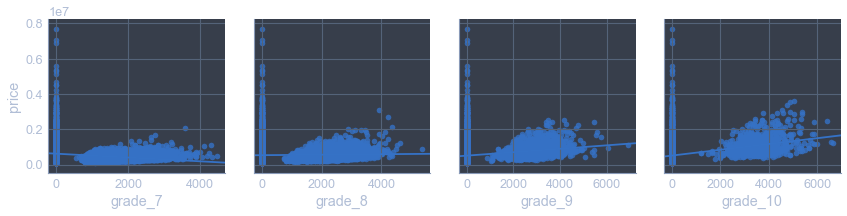

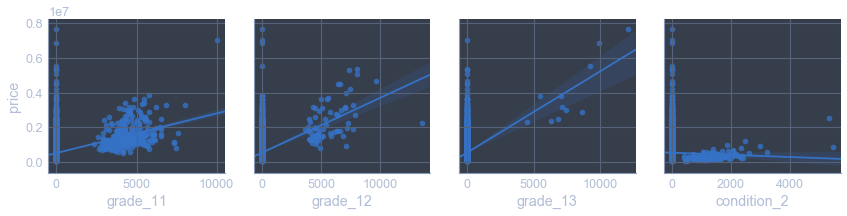

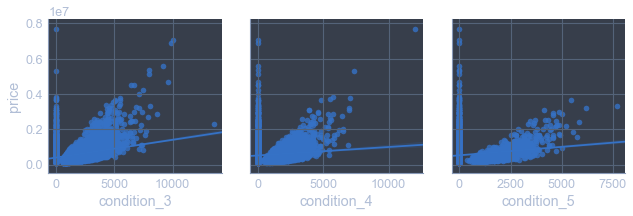

In [63]:
# Function to create feature pplots
def pplot_features(df, features):
    pp_rows = [features[i:i+4] for i in range(0, len(features), 4)]
    for row in pp_rows:
        pp = sns.pairplot(data=df, y_vars=['price'], x_vars=row, kind='reg', height=3)
    return None

# Create feature pplots for training df
pplot_features(train_df, features)

# Split Data Into Train/Test

In [107]:
# Fucntion to split data into test and train data
def tt_split(df):
    ignore = ['Unnamed: 0', 'id', 'price', 'date', 'yr_built', 'zipcode',
          'lat', 'long', 'sqft_living', 'sqft_above','grade', 'condition']
    Y = df['price']
    for col in ignore:
        df = df.drop(columns=col, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(df, Y, random_state=22,test_size=0.2)
    return x_train, x_test, y_train, y_test

# Split training data into test and train data
x_train, x_test, y_train, y_test = tt_split(train_df)

# Simple Regression Model

In [108]:
# Simple regression model on training data
model = sm.OLS(y_train, sm.add_constant(x_train[[key for key in x_train]])).fit()
model.summary()

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     1066.
Date:                Mon, 04 May 2020   Prob (F-statistic):               0.00
Time:                        14:04:49   Log-Likelihood:            -1.8172e+05
No. Observations:               13832   AIC:                         3.637e+05
Df Residuals:                   13724   BIC:                         3.645e+05
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.648e+05   7907.922     20.836      0.000    1.49e+05     1.8e+05
bedrooms      -9867.4425   1555.487     -6.344      0.000   -1.29e+04   -6818.475
bathrooms      2.019e+04   2541.811      7.942      0.000    1.52e+04    2.52e+04
sqft_lot          0.5432      0.055      9.947      0.000       0.436       0.650
floors        -3.392e+04   2990.419    -11.341      0.000   -3.98e+04   -2.81e+04
waterfront      218.1907      3.612     60.403      0.000     211.110     225.271
view           4.322e+04   1674.902     25.803      0.000    3.99e+04    4.65e+04
sqft_basement   -76.2929      3.602    -21.179      0.000     -83.354     -69.232
yr_renovated    828.7848     87.691      9.451      0.000     656.898    1000.671
sqft_living15    58.0010      2.811     20.636      0.000      52.492      63.510
sqft_lot15       -0.1269      0.074     -1.711      0.087      -0.272       0.018
age               4.7681     61.156      0.078      0.938    -115.106     124.642
2015             34.6892      3.187     10.884      0.000      28.442      40.937
2                 0.3331      2.970      0.112      0.911      -5.489       6.155
3                11.0923      2.769      4.005      0.000       5.664      16.520
4                16.9055      2.649      6.383      0.000      11.714      22.097
5                26.6244      3.549      7.503      0.000      19.669      33.580
6                32.6706      4.130      7.911      0.000      24.576      40.765
7                32.4867      4.136      7.855      0.000      24.380      40.593
8                33.9373      4.177      8.126      0.000      25.751      42.124
9                30.4010      4.212      7.218      0.000      22.145      38.657
10               32.8164      4.177      7.857      0.000      24.629      41.003
11               31.7574      4.285      7.411      0.000      23.358      40.157
12               33.4228      4.286      7.799      0.000      25.022      41.823
98002            -4.6449      7.473     -0.622      0.534     -19.294      10.004
98003            -5.3717      6.009     -0.894      0.371     -17.151       6.407
98004           301.9659      5.048     59.816      0.000     292.071     311.861
98005           128.6104      5.899     21.802      0.000     117.047     140.173
98006           119.0347      4.809     24.753      0.000     109.609     128.461
98007           123.5406      7.169     17.232      0.000     109.488     137.594
98008           122.1258      5.776     21.142      0.000     110.803     133.448
98010            32.0924      7.765      4.133      0.000      16.871      47.314
98011            66.7348      6.319     10.562      0.000      54.350      79.120
98014            52.9844      7.192      7.367      0.000      38.887      67.081
98019            43.9448      6.355      6.915   

# Lasso Model

In [109]:
lasso = Lasso(alpha=0.01, normalize=False)
lasso.fit(x_train, y_train)
y_train_pred = lasso.predict(x_train)
y_test_pred = lasso.predict(x_test)

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104403667521712.39, tolerance: 194381627077.73962
  positive)


In [110]:
train_rmse = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )

Training Error: 75633.05762270217
Testing Error: 129554.0172576651


In [111]:
lasso_coef = pd.DataFrame(data=lasso.coef_).T
lasso_coef.columns = x_train.columns
lasso_coef = lasso_coef.T.sort_values(by=0).T

lasso_coef

,floors,bedrooms,grade_3,grade_4,grade_5,grade_6,sqft_basement,grade_7,grade_8,grade_9,...,98105,98109,98119,98112,98102,98004,98039,yr_renovated,bathrooms,view
0,-34005.259216,-10012.090571,-269.24284,-153.553497,-112.096046,-88.952477,-76.421956,-67.630202,-48.241922,-26.439389,...,234.161177,265.39249,274.539081,279.776726,281.485212,300.61641,378.757036,831.375787,20075.967612,43228.552369


# Final Model

In [112]:
# Columns to ignore
ignore = ['Unnamed: 0', 'id', 'price', 'date', 'yr_built', 'zipcode',
          'lat', 'long', 'sqft_living', 'sqft_above','grade', 'condition']

# Final training data
y_all = train_df['price']
x_all = train_df.drop(columns=ignore, axis=1)

# Holdout data
x_hold = hold_df.drop(columns=ignore, axis=1)

In [113]:
# Simple regression model
model_all = sm.OLS(y_all, sm.add_constant(x_all[[key for key in x_all]])).fit()
model_all.summary()

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     1297.
Date:                Mon, 04 May 2020   Prob (F-statistic):               0.00
Time:                        14:05:00   Log-Likelihood:            -2.2730e+05
No. Observations:               17290   AIC:                         4.548e+05
Df Residuals:                   17182   BIC:                         4.557e+05
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           1.66e+05   7143.285     23.239      0.000    1.52e+05     1.8e+05
bedrooms      -8816.7664   1409.472     -6.255      0.000   -1.16e+04   -6054.058
bathrooms      2.111e+04   2284.641      9.240      0.000    1.66e+04    2.56e+04
sqft_lot          0.5569      0.050     11.105      0.000       0.459       0.655
floors        -3.095e+04   2690.055    -11.504      0.000   -3.62e+04   -2.57e+04
waterfront      221.6330      3.333     66.504      0.000     215.101     228.165
view           4.313e+04   1504.224     28.673      0.000    4.02e+04    4.61e+04
sqft_basement   -70.6610      3.231    -21.868      0.000     -76.994     -64.328
yr_renovated    906.9938     78.655     11.531      0.000     752.823    1061.165
sqft_living15    57.1451      2.533     22.562      0.000      52.181      62.110
sqft_lot15       -0.1361      0.068     -2.013      0.044      -0.269      -0.004
age               1.3836     54.947      0.025      0.980    -106.318     109.085
2015             38.3607      2.863     13.397      0.000      32.748      43.973
2                 0.8914      2.665      0.334      0.738      -4.333       6.115
3                10.5359      2.469      4.267      0.000       5.696      15.376
4                16.0611      2.368      6.784      0.000      11.420      20.702
5                29.0924      3.168      9.184      0.000      22.884      35.301
6                35.8852      3.702      9.694      0.000      28.629      43.141
7                34.3146      3.703      9.267      0.000      27.057      41.572
8                36.6249      3.745      9.780      0.000      29.284      43.966
9                33.9096      3.774      8.986      0.000      26.513      41.306
10               36.0380      3.746      9.621      0.000      28.696      43.380
11               34.9504      3.836      9.111      0.000      27.432      42.469
12               36.0264      3.827      9.414      0.000      28.526      43.527
98002            -5.5029      6.894     -0.798      0.425     -19.016       8.010
98003            -6.0837      5.434     -1.120      0.263     -16.735       4.567
98004           297.6910      4.520     65.864      0.000     288.832     306.550
98005           131.0847      5.279     24.829      0.000     120.736     141.433
98006           119.8972      4.293     27.926      0.000     111.482     128.313
98007           125.6773      6.345     19.808      0.000     113.241     138.114
98008           127.5720      5.205     24.510      0.000     117.370     137.774
98010            31.1308      7.184      4.333      0.000      17.050      45.212
98011            68.5559      5.548     12.356      0.000      57.681      79.431
98014            50.7588      6.494      7.816      0.000      38.030      63.488
98019            45.0192      5.785      7.782   

In [114]:
# Lasso model
lasso_all = Lasso(alpha=0.01, normalize=False)
lasso_all.fit(x_all, y_all)
y_hold = lasso_all.predict(x_hold)

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132759657996334.48, tolerance: 240951709851.4366
  positive)


In [115]:
y_hold

array([446944.09564787, 452861.30267342, 329519.88245287, ...,
       301162.17077577, 334429.61662531, 301274.03354343])

# Save Results

In [116]:
csv = pd.DataFrame(y_hold)

In [118]:
csv.to_csv('housing_preds_Jesse_Eric.csv', header=None)

# Notes (TESTING)

In [28]:
# # Recreate original dataframe without any added columns
# TESTING = pd.read_csv('kc_house_data_train.csv')

# # Create features list for original dataframe
# TESTING_FEATURES = set_features(TESTING)

# # Run model on original dataframe
# set_model(TESTING, TESTING_FEATURES)

# Unused Functions

In [29]:
# # Function to create target variable
# def set_target(df):
#     target = df['price']
#     return target

# # Create target variable for dataframes
# train_target = set_target(train_df)
# test_target = set_target(test_df)

In [30]:
# # Function for creating grade dummy variables
# def set_grades(df):
#     dummies = pd.get_dummies(df['grade'], prefix='grade', drop_first=True)
#     df = pd.concat([df, dummies], axis=1)
#     return df

# # Create grade dummy variables for dataframes
# train_df = set_grades(train_df)
# holdout_df = set_grades(holdout_df)

In [31]:
# # Function to transform bedrooms outliers
# def bedrooms_trans(df):
#     filt = df['bedrooms'] < 10
#     df['bedrooms'] = np.where(filt, df['bedrooms'], 10)
#     return df

# # Transform bedrooms outliers in dataframes 
# train_df = bedrooms_trans(train_df)
# hold_df = bedrooms_trans(hold_df)

In [32]:
# # Function to transform bathrooms outliers
# def bathrooms_trans(df):
#     low_filt = df['bathrooms'] > .5
#     df['bathrooms'] = np.where(low_filt, df['bathrooms'], .5)
#     high_filt = df['bathrooms'] < 5
#     df['bathrooms'] = np.where(high_filt, df['bathrooms'], 5)
#     return df

# # Transform bedrooms outliers in dataframes 
# train_df = bathrooms_trans(train_df)
# hold_df = bathrooms_trans(hold_df)

In [33]:
# # Function to create regression modeln (smf method)
# def set_model(df, features):
#     formula = 'price~' + '+'.join([f'{ft}' for ft in features])
#     model = smf.ols(formula=formula, data=df).fit()
#     return model.summary()

# # Run model on train dataframe
# set_model(train_df, train_features)

In [34]:
# # Function to create age range dummy variables
# def set_ages(df):
#     year = df['yr_built']
#     # df['age_new'] = np.where(age==2015, 1, 0)
#     df['age_10'] = np.where((year>2004) & (year<2015), 1, 0)
#     df['age_20'] = np.where((year>1994) & (year<2005), 1, 0)
#     df['age_30'] = np.where((year>1984) & (year<1995), 1, 0)
#     df['age_40'] = np.where((year>1974) & (year<1985), 1, 0)
#     df['age_50'] = np.where((year>1964) & (year<1975), 1, 0)
#     df['age_60'] = np.where((year>1954) & (year<1965), 1, 0)
#     df['age_70'] = np.where((year>1944) & (year<1955), 1, 0)
#     df['age_80'] = np.where((year>1934) & (year<1945), 1, 0)
#     df['age_90'] = np.where((year>1924) & (year<1935), 1, 0)
#     df['age_100'] = np.where((year>1914) & (year<1925), 1, 0)
#     df['age_old'] = np.where((year<1915), 1, 0)
#     return df

# # Create age range dummy variables for dataframes
# # train_df = set_ages(train_df)
# # hold_df = set_ages(hold_df)

In [35]:
# # Function to create renovation age range dummy variables
# def set_ren_ages(df):
#     year = df['yr_built']
#     ren_yr = df['yr_renovated']
#     df['not_ren'] = np.where((year!=2015) & (ren_yr==0), 1, 0)
#     df['ren_5'] = np.where((ren_yr>2010), 1, 0)
#     df['ren_10'] = np.where((ren_yr>2005) & (ren_yr<2011), 1, 0)
#     df['ren_15'] = np.where((ren_yr>2000) & (ren_yr<2006), 1, 0)
#     df['ren_20'] = np.where((ren_yr>1995) & (ren_yr<2001), 1, 0)
#     df['ren_25'] = np.where((ren_yr>1990) & (ren_yr<1996), 1, 0)
#     df['ren_30'] = np.where((ren_yr>1985) & (ren_yr<1991), 1, 0)
#     # df['ren_old'] = np.where((ren_yr>0) & (ren_yr<1986), 1, 0)
#     return df

# # Create renovation age range dummy variables for dataframes
# # train_df = set_ren_ages(train_df)
# # hold_df = set_ren_ages(hold_df)

In [36]:
# # Transform grade variable
# df_test = train_df
# df_test['grade_log'] = df_test['grade'].apply(lambda x: math.log(x))

# df_test = train_df
# df_test['grade_exp'] = df_test['grade'].apply(lambda x: math.exp(x))

# df_test = train_df
# df_test['price_log'] = df_test['price'].apply(lambda x: math.log(x))


# test1 = df_test.groupby('grade_exp')['price'].mean()
# fig, ax = plt.subplots()
# ax.scatter(test1.index, test1.values)

In [37]:
# # Function to create features list
# def set_features(df):
#     ignore = ['Unnamed: 0', 'id', 'price', 'date', 'yr_built', 'zipcode',
#               'lat', 'long', 'sqft_living', 'sqft_above']
#     features = list(df.keys())
#     for feature in ignore:
#         if feature in features:
#             features.remove(feature)
#     return features

# # Create features list for dataframes
# features = set_features(train_df)

In [38]:
# # Function to create regression model
# def set_model(df, features):
#     model = sm.OLS(y_train, sm.add_constant(
#         df[[key for key in features]])).fit()
#     return model.summary()
# # Run model on training dataframe
# set_model(train_df, features)

In [39]:
# # Split into x dataframes and y series for train and test data
# Y = train_df['price']
# X = train_df.drop(['price'], axis=1)
# x_train, x_test, y_train, y_test = train_test_split(
#     X, Y, random_state=22,test_size=0.2)